In [2]:
# Check nvcc version
!nvcc -V

# Install PyTorch
!pip install torch torchvision
# # Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0

!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -e .

# Check Pytorch installation
import torch
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg as mmseg
print(mmseg.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_19:00:59_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
2.0.0+cu118 True
1.0.0


In [3]:
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints
!wget https://conversationhub.blob.core.windows.net/beit-share-public/beit/beit_base_patch16_224_pt22k_ft22k.pth -P checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/resnest/deeplabv3plus_s101-d8_512x512_160k_ade20k/deeplabv3plus_s101-d8_512x512_160k_ade20k_20200807_144503-27b26226.pth -P checkpoints
!wget https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth -P checkpoints


In [5]:
from google.colab import drive
drive.mount('/content/drive/')


!mkdir dataset
!cp /content/drive/MyDrive/Interior/compiled_dataset.zip /content/mmsegmentation/dataset/
!ls
!unzip /content/mmsegmentation/dataset/compiled_dataset.zip -d /content/mmsegmentation/dataset/

In [6]:

# config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
# checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
#
# config_file = 'configs/resnest/resnest_s101-d8_deeplabv3plus_4xb4-160k_ade20k-512x512.py'
# checkpoint_file = 'checkpoints/deeplabv3plus_s101-d8_512x512_160k_ade20k_20200807_144503-27b26226.pth'

config_file = 'configs/swin/swin-tiny-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512.py'
checkpoint_file = 'checkpoints/swin_tiny_patch4_window7_224.pth'

# config_file= 'configs/resnest/resnest_s101-d8_deeplabv3plus_4xb4-160k_ade20k-512x512.py'
# checkpoint_file = 'checkpoints/5k_iters_2k_img.pth'

# config_file = '/content/mmsegmentation/configs/beit/upernet_beit-base_640x640_160k_ade20k_ms.py'
# config_file = 'upernet_beit-base_8x2_640x640_160k_ade20k.py'
# checkpoint_file = '/content/mmsegmentation/pretrain/beit_base_patch16_224_pt22k_ft22k.pth'

# config_file = '/content/mmsegmentation/configs/vit/upernet_deit-b16_512x512_80k_ade20k.py'
# checkpoint_file = '/content/mmsegmentation/pretrain/jx_vit_base_p16_224-80ecf9dd.pth'

classes = ['wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'counter', 'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 'mirror', 'floor', 'clothes', 'ceiling', 'books', 'refridgerator', 'television', 'paper', 'towel', 'shower', 'box', 'whiteboard', 'person', 'night', 'toilet', 'sink', 'lamp', 'bathtub', 'bag', 'otherstructure', 'otherfurniture', 'otherprop']

palette = [[118, 21, 12], [55,125,33], [129,129,32], [0,0,116], [117,21,124], [56, 127, 128], [129,129,129], [56, 5, 3], [177, 36, 24], [56,5,59], [184,132,44], [56,5,124], [188,0,5] ,[79,127,128], [184,132,130], [23,61,11], [116,63,19], [65,142,41], [143,192,58], [56,127,34], [0,0,0],  [87,191,134], [0,0,0], [62,62,14], [179,72,29], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,59],[56,127,69], [129,129,71], [0,0,185], [0,0,0], [0,0,0],[129,129,189], [0,0,0],[0,0,0], [111,111,111]]


['wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'counter', 'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 'mirror', 'floor', 'clothes', 'ceiling', 'books', 'refridgerator', 'television', 'paper', 'towel', 'shower', 'box', 'whiteboard', 'person', 'night', 'toilet', 'sink', 'lamp', 'bathtub', 'bag', 'otherstructure', 'otherfurniture', 'otherprop']
40


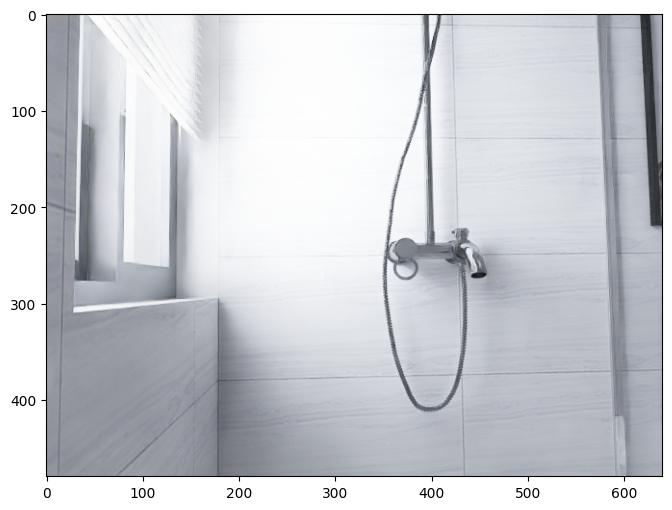

In [7]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt

img = mmcv.imread('dataset/compiled_dataset/cam/0.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [9]:
import os.path as osp
import wandb

data_root = 'dataset/compiled_dataset/'

img_dir = 'cam/'
ann_dir = 'label/'

# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [ ]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class InteriorNetDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)


In [10]:
from mmengine import Config
cfg = Config.fromfile(config_file)
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
backbone_norm_cfg = dict(type='LN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 512))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 512)),
    pretrained=None,
    backbone=dict(
        type='SwinTransformer',
        pretrain_img_size=224,
        embed_dims=96,
        patch_size=4,
        window_size=7,
        mlp_ratio=4,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        strides=(4, 2, 2, 2),
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        patch_norm=True,
        drop_

In [11]:


# RESNEST/PSPNET CONFIG
# cfg.norm_cfg = dict(type='BN', requires_grad=True)
# cfg.crop_size = (320,240)
# cfg.model.data_preprocessor.size = cfg.crop_size
# cfg.model.backbone.norm_cfg = cfg.norm_cfg
# cfg.model.decode_head.norm_cfg = cfg.norm_cfg
# cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg


# SWIN CONFIG
# cfg.norm_cfg = dict(type='BN', requires_grad=True)
# cfg.crop_size = (320,240)
# cfg.model.data_preprocessor.size = cfg.crop_size
# cfg.model.decode_head.norm_cfg = cfg.norm_cfg


# BEIT CONFIG
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (320,240)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
cfg.model.pretrained = checkpoint_file

cfg.model.test_cfg['crop_size'] = (320,240)
cfg.model.test_cfg['stride'] = (213,160)

cfg.data_preprocessor['size'] = (320,240)
cfg.model.backbone['img_size'] = (320,240)


# DATASET + Pipeline configs - stays the same for each model

cfg.model.decode_head.num_classes = 40
cfg.model.auxiliary_head.num_classes = 40

# Modify dataset type and path
cfg.dataset_type = 'InteriorNetDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]

cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader

cfg.visualizer.vis_backends = [dict(type='LocalVisBackend'),
                    dict(type='WandbVisBackend')]

# Load the pretrained weights
cfg.load_from = checkpoint_file

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.train_cfg.max_iters = 10000
cfg.train_cfg.val_interval = 500
cfg.default_hooks.logger.interval = 100
cfg.default_hooks.checkpoint.interval = 1000
cfg.default_hooks.visualization.interval = 500
cfg.default_hooks.visualization.draw = True

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
backbone_norm_cfg = dict(type='LN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 512))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(320, 240)),
    pretrained=None,
    backbone=dict(
        type='SwinTransformer',
        pretrain_img_size=224,
        embed_dims=96,
        patch_size=4,
        window_size=7,
        mlp_ratio=4,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        strides=(4, 2, 2, 2),
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        patch_norm=True,
        drop_rate

In [12]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

04/07 17:09:13 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce GTX 970
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.7
    NVCC: Cuda compilation tools, release 11.7, V11.7.64
    MSVC: n/a, reason: fileno
    PyTorch: 2.0.0+cu118
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,co

wandb: Currently logged in as: lc2232. Use `wandb login --relogin` to force relogin


K:\PycharmProjects\InteriorSegmentor\mmsegmentation\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
K:\PycharmProjects\InteriorSegmentor\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


04/07 17:09:24 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
04/07 17:09:24 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

In [13]:
# start training
runner.train()

04/07 17:09:38 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.weight:lr=6e-05
04/07 17:09:38 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.weight:weight_decay=0.0
04/07 17:09:38 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.weight:decay_mult=0.0
04/07 17:09:38 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.bias:lr=6e-05
04/07 17:09:38 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.bias:weight_decay=0.0
04/07 17:09:38 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.bias:decay_mult=0.0
04/07 17:09:38 - mmengine - INFO - paramwise_options -- backbone.stages.0.blocks.0.norm1.weight:lr=6e-05
04/07 17:09:38 - mmengine - INFO - paramwise_options -- backbone.stages.0.blocks.0.norm1.weight:weight_decay=0.0
04/07 17:09:38 - mmengine - INFO - paramwise_options -- backbone.stages.0.blocks.0.norm1.weight:decay_mult=0.0
04/07 17:09:38 - mmengine - INFO - paramwise_options -- backb

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (stages): ModuleList(
      (0): SwinBlockSequence(
        (blocks): ModuleList(
          (0-1): 2 x SwinBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftWindowMSA(
              (w_msa): WindowMSA(
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop): DropPath()
            )
       

K:\PycharmProjects\InteriorSegmentor\mmsegmentation\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
K:\PycharmProjects\InteriorSegmentor\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: work_dirs/tutorial/iter_10000.pth
40
40


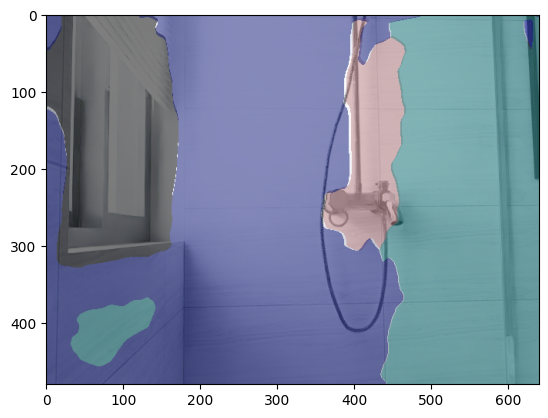

In [16]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# # Init the model from the config and the checkpoint
checkpoint_path = 'work_dirs/tutorial/iter_100.pth'
model = init_model(cfg, checkpoint_path,'cuda:0')

# print(len(model.dataset_meta['classes']))

img = mmcv.imread('dataset/compiled_dataset/cam/0.png')
result = inference_model(model, img)
vis_result = show_result_pyplot(model, img, result, save_dir='output.jpg')
plt.imshow(mmcv.bgr2rgb(vis_result))

In [15]:
wandb.finish()

aAcc,▁▄▅▆▅▆▇▆▇▆▇█▇█▇█████
aux.acc_seg,▁▃▄▅█▃▄▅▇██▇▄▅▇▅▆▄▅▅▆██▇▆█▆██▇▅▅▇▇▅▇▆█▅▆
aux.loss_ce,█▇▆▄▄▃▃▃▂▂▂▂▃▂▂▂▂▃▂▁▂▂▂▁▂▂▂▁▁▂▂▂▂▁▁▁▁▂▂▁
data_time,▅▁▅▃▆▇▃▂▇▃▅▇▆▃▃▆▁▃▄▆▂▃▄▁▆▄▆▄▂▅█▄█▄▆▆▄▃▆▁
decode.acc_seg,▁▅▄▆▇▃▄▅▇▇▇▇▄▅▇▅▆▄▅▄▆██▇▅█▆▇█▆▆▅▇▇▅▇▅▇▅▆
decode.loss_ce,█▆▄▃▂▂▂▃▂▂▁▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▂▁▁▂▁▂▂▁▁▁▁▂▂▁
loss,█▆▅▃▃▂▂▃▂▂▁▂▂▂▂▂▂▃▂▁▂▂▁▁▂▂▂▁▁▂▁▂▂▁▁▁▁▂▂▁
lr,▁▂▄▅▆▇██████████████████████████████████
mAcc,▁▃▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
mIoU,▁▃▃▄▅▆▆▆▆▆▇▇▇█▇▇▇███
memory,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
